# LGBM을 활용한 베이스라인

In [27]:
import pandas as pd
import os
import random
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

## 1. 데이터 로딩

In [28]:
data_dir = '/opt/ml/input/data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [29]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [30]:
df[df['userID'].shift(1) != df['userID']]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
745,1,A040013001,A040000013,1,2020-01-06 08:40:43,2048
1678,2,A030050001,A030000050,1,2020-01-10 11:02:53,407
1954,5,A080001001,A080000001,1,2020-02-12 20:00:20,4604
2787,6,A030016001,A030000016,1,2020-03-09 10:48:28,7307
...,...,...,...,...,...,...
2266515,7436,A050095001,A050000095,1,2020-03-03 06:34:05,360
2266530,7437,A040072001,A040000072,1,2020-03-24 07:45:15,2076
2266546,7438,A080002001,A080000002,1,2020-02-25 20:59:54,4605
2266562,7440,A050096001,A050000096,1,2020-08-19 04:57:19,5267


In [31]:
df = feature_engineering(df)

In [36]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.947683,1268,0.913187,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,4,0.250000,0.662590,921,0.689706,2814
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,5,0.200000,0.655109,718,0.697874,2199
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2.0,6,0.333333,0.655109,718,0.697874,2199
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3.0,7,0.428571,0.655109,718,0.697874,2199


## 3. Train/Test 데이터 셋 분리

In [72]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    random.seed(42)
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [82]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [83]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [84]:
model = lgb.train(
    {'objective':'binary'},
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100,
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.559427	valid_1's binary_logloss: 0.681014
[200]	training's binary_logloss: 0.556528	valid_1's binary_logloss: 0.680677
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.558699	valid_1's binary_logloss: 0.680181
VALID AUC : 0.6904581594116477 ACC : 0.6098654708520179



In [68]:
lgb.Booster.feature_name(model)

['KnowledgeTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'test_mean',
 'test_sum',
 'tag_mean',
 'tag_sum']

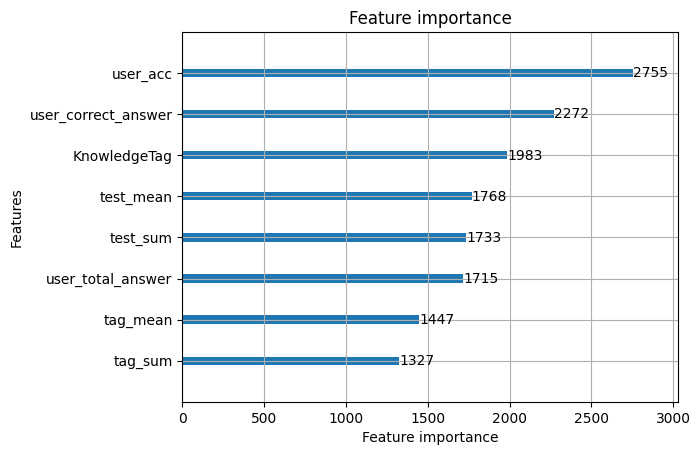

In [10]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [12]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [13]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])
total_preds.mean()

0.6056208256418228

In [27]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM_Baseline_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv
